In [19]:
from gdc.data_access import *
from gdc.pricing import *
from gdc.utils import GDC_DATA_PATH
import pandas as pd
from os import path
import numpy as np
import seaborn as sns

In [13]:
df_load_simulated_normalized.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2023-01-01 00:00:00,0.308875,0.241084,0.435789,0.424829,0.239696,0.618679,0.201332,0.002316,0.537362,0.863129,...,0.848488,0.609326,0.750540,0.509708,0.675622,0.224907,1.116675,0.979219,1.214080,1.667707
2023-01-01 01:00:00,0.325552,0.246717,0.424862,0.387153,2.523461,0.619000,0.220604,1.393032,1.130548,0.721798,...,6.277924,0.935558,0.704712,0.445823,0.709091,0.192008,1.053277,0.809944,1.277540,5.152804
2023-01-01 02:00:00,3.468337,0.245007,2.300304,0.389507,0.987357,2.315828,2.433891,0.151374,0.877162,0.589248,...,1.191456,1.541097,0.711532,0.605748,0.757926,0.215429,0.839848,0.714650,1.375509,6.028554
2023-01-01 03:00:00,2.215840,1.272533,2.411101,0.382058,0.542293,1.898651,0.208088,0.123750,0.581648,0.515496,...,1.093116,1.073977,0.719326,1.533871,0.714349,0.228124,0.816399,1.518087,2.130233,4.159936
2023-01-01 04:00:00,1.259481,1.027133,0.483457,0.393334,0.380745,2.999703,0.152132,0.158867,1.667804,0.507242,...,1.070443,0.826959,0.757065,0.524391,0.865323,0.203812,0.809643,0.820883,6.877547,3.808041


In [14]:
df_hourly_prices.head()

,Price_EUR_MWh
date,
2023-01-01 00:00:00,-0.10
2023-01-01 01:00:00,-1.33
2023-01-01 02:00:00,-4.08
2023-01-01 03:00:00,-4.16
2023-01-01 04:00:00,-3.58


<Axes: xlabel='date'>

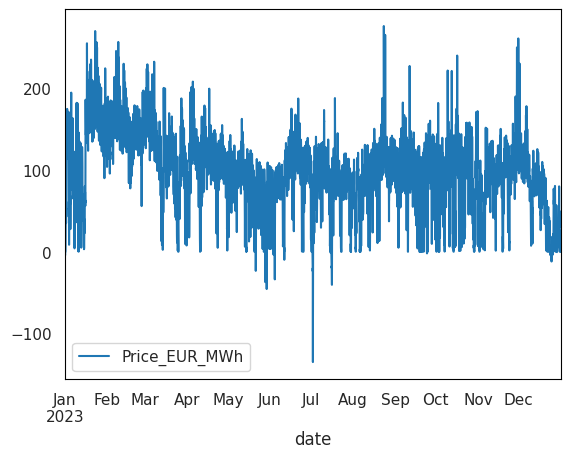

In [15]:
df_hourly_prices.plot()

In [16]:
dic_profits_by_power = {}

for p in [6, 9, 12]:
    this_loads = df_load_simulated_normalized.loc[:, get_subscribers(p)]
    dic_profits_by_power[p] = compute_simulated_base_variable_profit_ht(p, this_loads, df_hourly_prices)

<Axes: >

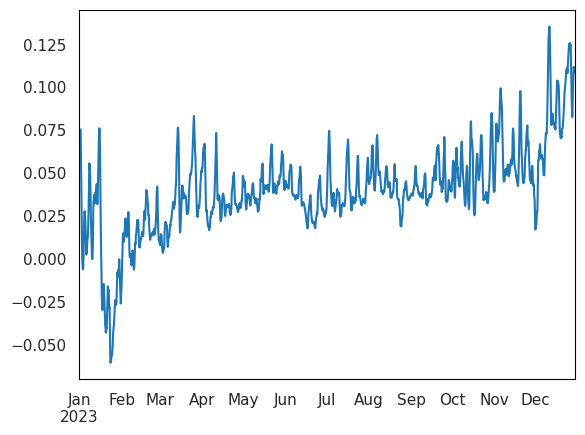

In [17]:
profits_6 = dic_profits_by_power[6]

profits_6.mean(axis=1).rolling(24).mean().plot()

In [99]:
mean_profits = predicted_moments(profits_6, df_temp_simulated_normalized, 'quantile', .75)

/home/sylvain857/.virtualenvs/py311-gdc/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


In [100]:
mean_profits.shape

(8712, 3309)

In [101]:
coef = 0.
prediction_error = (profits_6 - mean_profits - coef * np.abs(mean_profits)).sum(axis=0)
prediction_error.mean()

np.float64(-75.71919997369486)

<Axes: ylabel='Proportion'>

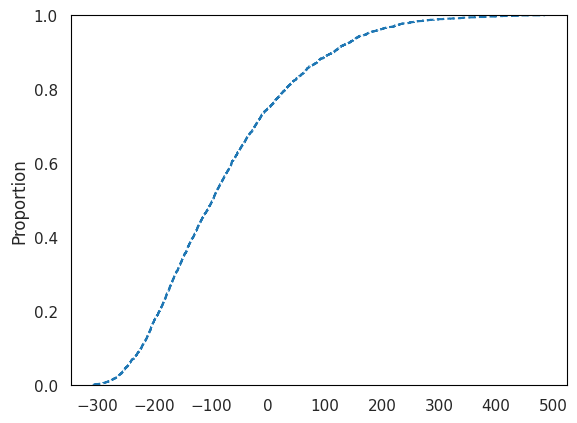

In [102]:
sns.ecdfplot(prediction_error)

In [103]:
prediction_error.sum()

np.float64(-250554.83271295627)

In [104]:
total_profits = profits_6.sum().sum()
total_profits

np.float64(1166187.364502724)

In [105]:
error_margin = prediction_error.clip(0).sum()

In [106]:
error_margin / total_profits

np.float64(0.07748131354427312)